In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import pickle
import multigoal

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class BehaviorCloningPolicy(object):
    def __init__(self, obs_dim, act_dim, n_mixture=4):
        self.n_mixture = n_mixture
        self.epochs = 20
        self.lr = None
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.max_std = 0.003
            
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        """ Build and initialize TensorFlow graph """
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        """ Input placeholders"""
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'eta')
        
    def _policy_nn(self):
        
        hid1_size = 64  # 10 empirically determined
        hid2_size = 64
        
        self.lr = 3e-4  # 9e-4 empirically determined
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="h2")
        means = tf.layers.dense(out, self.act_dim*self.n_mixture,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), 
#                                 bias_initializer=tf.random_uniform_initializer(minval=-1.0,maxval=1.0), 
                                name="flat_means")
        self.means = tf.reshape(means,shape=[-1,self.act_dim,self.n_mixture], name="means")
        
#         logits_std = tf.get_variable('logstd', [1, self.act_dim, self.n_mixture], tf.float32, tf.constant_initializer(-1.0))
        logits_std = tf.layers.dense(out, self.act_dim*self.n_mixture,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), 
                                name="flat_logits_std")
        self.std = tf.reshape(self.max_std*tf.sigmoid(logits_std),shape=[-1,self.act_dim,self.n_mixture], name="std")

        self.pi = tf.nn.softmax(tf.layers.dense(out, self.n_mixture,
                                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="pi"))
        
    def _logprob(self):
        """ Calculate log probabilities of a batch of observations & actions
        Calculates log probabilities using previous step's model parameters and
        new parameters being trained.
        """
        y = self.act_ph 
        mu = self.means
        sigma = self.std
        pi = self.pi
        
        quadratics = -0.5*tf.reduce_sum(tf.square((tf.tile(y[:,:,tf.newaxis],[1,1,self.n_mixture])-mu)/sigma),axis=1)
        logdet = -0.5*tf.reduce_sum(tf.log(sigma),axis=1)
        logconstant = - 0.5*self.act_dim*np.log(2.*np.pi)
        logpi = tf.log(pi)
        
        exponents = quadratics + logdet + logconstant + logpi
        logprobs = tf.reduce_logsumexp(exponents,axis=1)
        
        self.logp = logprobs

    def _loss_train_op(self):
        """
        Three loss terms:
            1) standard policy gradient
            2) D_KL(pi_old || pi_new)
            3) Hinge loss on [D_KL - kl_targ]^2
        See: https://arxiv.org/pdf/1707.02286.pdf
        """
        self.loss = -tf.reduce_mean(self.logp) 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)

    def _init_session(self):
        """Launch TensorFlow session and initialize variables"""
        self.sess = tf.Session(graph=self.g)
        self.sess.run(self.init)

    def sample(self, obs):
        """Draw sample from policy distribution"""
        feed_dict = {self.obs_ph: obs}

        pi, mu, sigma = self.sess.run([self.pi, self.means, self.std],feed_dict=feed_dict)
        
        n_points = np.shape(obs)[0]
        
        _y_sampled = np.zeros([n_points,self.act_dim])
        for i in range(n_points):
            k = np.random.choice(self.n_mixture,p=pi[i,:])
            _y_sampled[i,:] = mu[i,:,k] + np.random.randn(1,self.act_dim)*sigma[i,:,k]
        return _y_sampled
    
    def fit(self, x, y, batch_size=128):
        """ Fit model to current data batch + previous data batch
        Args:
            x: features
            y: target
            logger: logger to save training loss and % explained variance
        """
        num_batches = max(x.shape[0] // batch_size, 1)
        batch_size = x.shape[0] // num_batches
        
        x_train = x
        y_train = y
        for e in range(self.epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: x_train[start:end, :],
                             self.act_ph: y_train[start:end, :],
                             self.lr_ph: self.lr}
                _, l = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
        feed_dict = {self.obs_ph: x_train, self.act_ph: y_train, self.lr_ph: self.lr}
        loss = self.sess.run(self.loss, feed_dict=feed_dict)
        return loss
        
    def save_policy(self, path):
        saver = tf.train.Saver(self.variables)
        saver.save(self.sess, path+'/mdn'+str(self.n_mixture)+'_bc_policy.ckpt')

    def close_sess(self):
        """ Close TensorFlow session """
        self.sess.close()

In [3]:
def run_episode(env, policy, animate=False):
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        if animate:
            env.render()
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        action = policy.sample(obs).reshape((1, -1)).astype(np.float32)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.concatenate(actions),
            np.array(rewards, dtype=np.float32), infos)


def run_policy(env, policy, episodes):
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, policy)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'true_rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

In [14]:
demo_file = open('./multigoal_expert_demo.pkl', 'r')
demonstrations, = pickle.load(demo_file)
print('Load {} data'.format(len(demonstrations)))
demonstrations = demonstrations[:10]

env = multigoal.MultiGoalEnv(nr_goal=4)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

observes = []
actions = []
for demonstration in demonstrations:
    for obs in demonstration['observes']:
        observes.append(obs)
    for act in demonstration['actions']:
        actions.append(act)
exp_ret = np.mean([np.sum(t['rewards']) for t in demonstrations])

demo_observes = np.asarray(observes)
demo_actions = np.asarray(actions)
policy = BehaviorCloningPolicy(obs_dim,act_dim,n_mixture=8)

nupdates = 1000
for update in range(nupdates+1):
    loss = policy.fit(demo_observes,demo_actions,batch_size=32)

    if (update%100) == 0:
        trajectories = run_policy(env, policy, 100)
        mean_ret = np.mean([t['true_rewards'].sum() for t in trajectories])
        print('****** Mean Ret : {:.3f}/{:.3f}, Policy Loss : {:.3f} ******'.format(mean_ret, exp_ret, loss))

Load 1000 data


Exception TypeError: "render() got an unexpected keyword argument 'close'" in <bound method MultiGoalEnv.__del__ of <multigoal.MultiGoalEnv object at 0x7f21cb95f790>> ignored


****** Mean Ret : 37.959/806.053, Policy Loss : 322.239 ******
****** Mean Ret : 106.564/806.053, Policy Loss : 31.720 ******
****** Mean Ret : 158.827/806.053, Policy Loss : 24.727 ******
****** Mean Ret : 197.290/806.053, Policy Loss : 18.673 ******
****** Mean Ret : 292.140/806.053, Policy Loss : 12.592 ******
****** Mean Ret : 381.139/806.053, Policy Loss : 11.227 ******
****** Mean Ret : 414.040/806.053, Policy Loss : 9.118 ******
****** Mean Ret : 418.461/806.053, Policy Loss : 6.479 ******
****** Mean Ret : 431.866/806.053, Policy Loss : 3.962 ******
****** Mean Ret : 381.370/806.053, Policy Loss : 2.596 ******
****** Mean Ret : 386.414/806.053, Policy Loss : 2.366 ******


Evaluation Result: 480.053106079


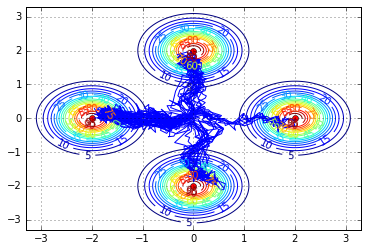

In [7]:
 def evaluation(env, policy, max_eval_epi=100, seed=0):
        return_list = np.zeros((max_eval_epi,))
        info_list = []
        
        env.seed(seed)
        for epi in range(max_eval_epi):
            obs = env.reset()
            env_infos_epi_list = {"pos": [],"goal_id": []}
            observes, actions, rewards, infos = run_episode(env, policy)
            
            pos_list = []
            goal_id_list = []
            for info in infos:
                pos_list.append(info["pos"])
                goal_id_list.append(info["goal_id"])
            env_infos_epi_list["pos"] = np.asarray(pos_list)
            env_infos_epi_list["goal_id"] = np.asarray(goal_id_list)
            
            info_list.append({"env_infos":env_infos_epi_list})
            return_list[epi] = np.sum(rewards)
        print("Evaluation Result: {}".format(np.mean(return_list)))
        return return_list, info_list
    
from matplotlib import pyplot as plt
%matplotlib inline
return_list, info_list = evaluation(env, policy, max_eval_epi=100)
env.plot_paths(info_list)
plt.draw()
plt.pause(0.005)

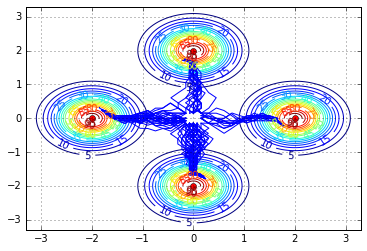

In [13]:
demo_file = open('./multigoal_expert_demo.pkl', 'r')
demonstrations, = pickle.load(demo_file)
demonstrations = demonstrations[:100]

info_list = []        
for demonstration in demonstrations:
    env_infos_epi_list = {"pos": [],"goal_id": []}
    pos_list = []
    goal_id_list = []
    for info in demonstration['infos']:
        pos_list.append(info["pos"])
        goal_id_list.append(info["goal_id"])
    env_infos_epi_list["pos"] = np.asarray(pos_list)
    env_infos_epi_list["goal_id"] = np.asarray(goal_id_list)
    info_list.append({"env_infos":env_infos_epi_list})
from matplotlib import pyplot as plt
%matplotlib inline
env.plot_paths(info_list)
plt.draw()
plt.pause(0.005)